##### FIR FILTER

##### Date: 8/12/2023

#### AIM: 
To implement an FIR filter using DSP Processor

#### THEORY:

The objective of designing an FIR filter is to determine a set of filter coefficients that satisfies the given specifications. A variety of techniques have been developed for designing FIR filters. The window method is one of the oldest and simplest. The window method involves multiplying the impulse response of an ideal filter with a window sequence that tapers smoothly to zero at each end. i.e. ℎ[𝑛]=ℎ𝑑[𝑛]𝑤[𝑛].

In order to design a low-pass FIR filter using the window method, we start with the impulse response of an ideal discrete-time low pass filter with linear phase response given by 

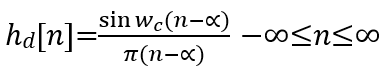

where 𝜔𝑐 is the cut-off frequency in radians/sample. Choose 

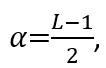

so that ℎ𝑑[𝑛 ] is symmetric about the point (L-1)/2 (either full-sample symmetric or half-sample symmetric depending on whether the length L of the filter is odd or even). Since all window sequences of length L are also symmetric about (L-1)/2, the resulting ℎ[𝑛]=ℎ𝑑[𝑛 ]𝑤[𝑛] is also symmetric and the filter will have a linear phase response.

Once the filter coefficients are determined, the filter can be implemented by the convolution formula 

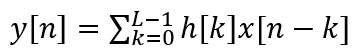

where the h[k]s are the coefficients of the length L FIR filter. In a software implementation, the filter coefficients and input samples are stored in arrays of length L. For each new input sample, an output sample is computed. This is called sample-by-sample processing in contrast with block processing. At some time, instant n0, the output 
𝑦[𝑛0]=ℎ[0]𝑥[𝑛0]+ℎ[1]𝑥[𝑛0−1]+ℎ[2]𝑥[𝑛0−2]+..+ℎ[𝐿−1]𝑥[𝑛0 −𝐿+1].

Note that the oldest input sample x[n0-L+1] is multiplied with the filter coefficient h[L-1] and the newest input sample x[n0] is multiplied with the filter coefficient h[0]. At this instant, the contents of the arrays h and x will be as follows:

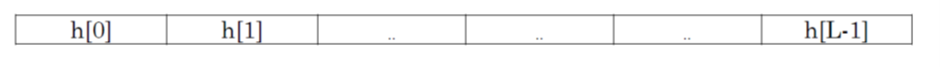

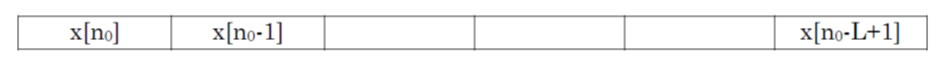

To compute 𝑦[𝑛0], the corresponding elements of the arrays are multiplied and the products are summed. 
At the next time instant n0+1, the output: 𝑦[𝑛0+1]=ℎ[0]𝑥[𝑛0+1]+ℎ[1]𝑥[𝑛0]+ℎ[2]𝑥[𝑛0−1]+..+ℎ[𝐿−1]𝑥[𝑛0 −𝐿+2] and therefore the array contents should be:

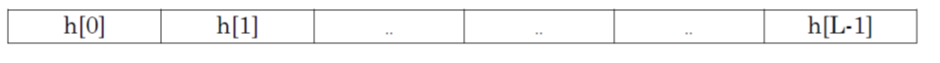

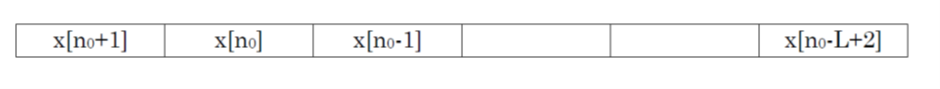

We see that filter coefficient array remains constant, but the input array is refreshed at every sampling instant. The oldest sample is discarded, the rest samples are shifted one location to the right in the buffer, and a new sample (from ADC in real-time applications) is inserted to the left. To compute the output at an instant, the corresponding elements of the arrays are multiplied and the products are summed. In the code below, we use the window method to design an FIR low pass filter for a cut-off frequency of 1 KHz and test it on real-time signals on the DSK. To convert the cut-off frequency in Hz to cut-off frequency in rad/sample, we use the relation 𝜔=Ω𝑇=2πF/F_s . Assuming a sampling frequency 𝐹𝑠=8𝐾𝐻𝑧,the cut-off frequency in rad/sample is 𝜔𝑐=2π1000/8000=π/4.

##### CODE:
```
#include<dsk6713.h> 
#include<dsk6713_aic23.h> 
#include<math.h> 
#define L 11 //length of filter 
int main(void) { 
    uint32 sample_pair; 
    float pi = 3.141592653589; 
    float hamming[L], h[L], x[L] = { 0 }, y;
    int i;

    //Generate Hamming window sequence 
    for (i = 0; i< L; i++) 
        hamming[i] = 0.54 - 0.46 * cos(2 * pi * i / (L - 1));

    //cut-off frequency of filter in rad/sample 
    float wc = pi / 4.0; 

    //compute filter coeffs
    for (i = 0; i< L; i++) 
    //avoid division by 0 when i=(L-1)/2 
        if (i == (L - 1) / 2) 
            h[i] = wc / pi * hamming[i];
        else 
            h[i] = sin(wc * (i - (L - 1) / 2.0)) / (pi*(i - (L - 1)/2.0)) * hamming[i];

    DSK6713_init(); 
    DSK6713_AIC23_Config config = DSK6713_AIC23_DEFAULTCONFIG; 
    DSK6713_AIC23_CodecHandlehCodec; 
    hCodec = DSK6713_AIC23_openCodec(0, &config);

    /* Change the sampling rate to 8 kHz */ 
    DSK6713_AIC23_setFreq(hCodec, DSK6713_AIC23_FREQ_8KHZ);

    while (1){ 
    while(!DSK6713_AIC23_read(hCodec, &sample_pair)); 

    //store top-half of sample from codec in x[0] 
    x[0] = (int)sample_pair>>16;

    //process input sample: 
    y = 0.0; 

    for (i = 0; i< L; i++) //compute filter output 
        y += h[i] * x[i];

    //shift delay line contents 
    for (i = (L - 1); i> 0; i--)
        x[i] = x[i - 1]; 

    //output y to left channel 
    sample_pair = (int)y <<16; 
    while(!DSK6713_AIC23_write(hCodec, sample_pair));
    } 

    /* Close the codec */ 
    DSK6713_AIC23_closeCodec(hCodec);
    return 0; 
}

```

##### Procedure: 
Code below reads pairs of left and right channel samples from the codec  ADC. The sampled signals are filtered using FIR low pass filter with cut off frequency wc and filter size L  and the filtered output is looped back to the codec DAC. The BSL function DSK6713_AIC23_read() is used to read a pair of samples from ADC and the function DSK6713_AIC23_write() isused to write a pair of samples to the DAC. Both functions use polling to read/write samples and returns 0 if codec is not ready and returns 1 if read/write is successful. The while loop continues till read/write is successful. Note that the function DSK6713_AIC23_read() uses a pointer variable. 
    
Build and Debug the program. Connect a 3.5mm aux cable from the headphone out of your PC (or phone). Connect a pair of headphones to the headphone out of the DSK. Verify that filter is working.


##### Result:
Successfully designed and implemented an FIR low pass filter with cut off frequency pi/4